In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=08a67c4c76355a08b4b40ee62e85e474bc22a2845dfa9bf9223e042ef4957789
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=89695b3a79196779e00cfc51a83c277e59fb9ac3046bda6a22031cc6e36555db
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 21.73 MiB/s, done.


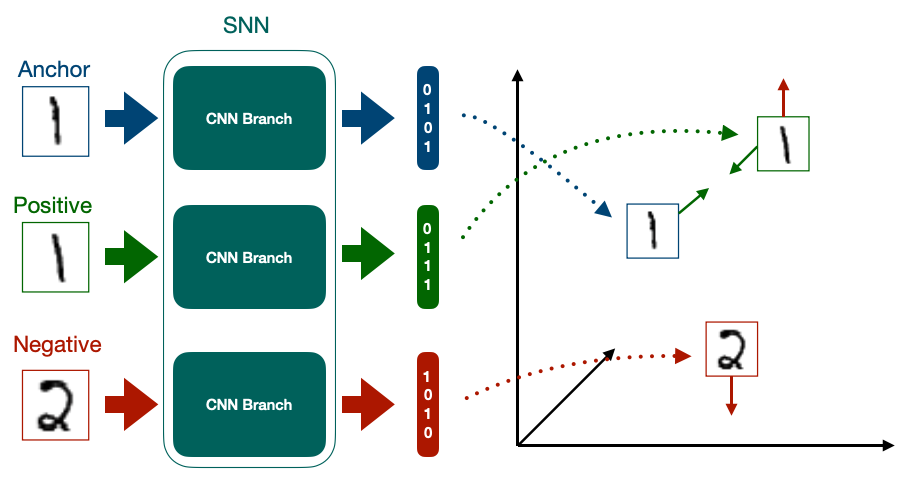

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

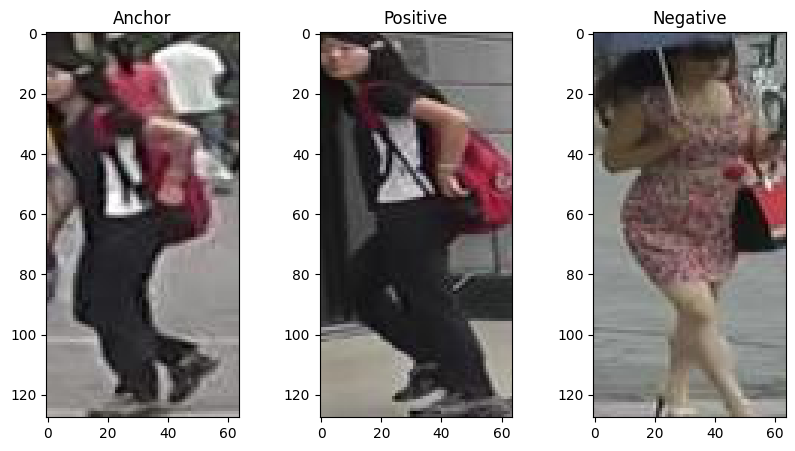

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset

In [12]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return (len(self.df))

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [14]:
train = APN_Dataset(train_df)
valid = APN_Dataset(valid_df)

print(f"Size of train data set: {len(train)}")
print(f"Size of validation data set: {len(valid)}")

Size of train data set: 3200
Size of validation data set: 800


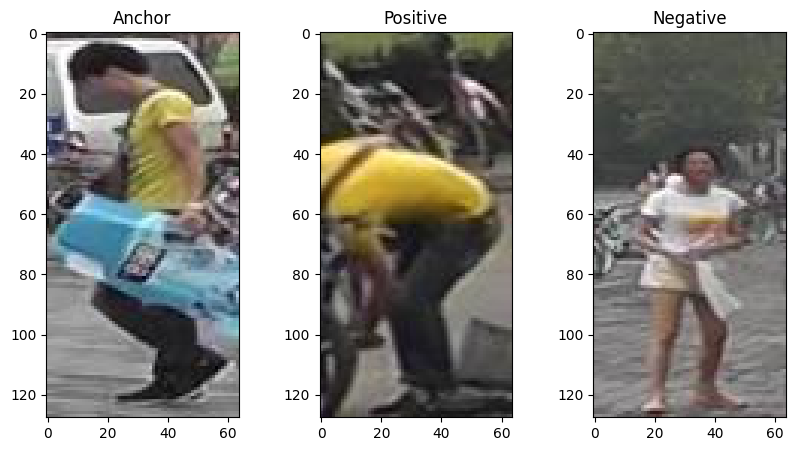

In [15]:
idx = 40
A,P,N = train[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [17]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE)

In [18]:
print(f"No. of batches in trainloader : {len(train_loader)}")
print(f"No. of batches in validloader : {len(valid_loader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [19]:
for A, P, N in train_loader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [25]:
class APN_Model(nn.Module):

  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()

    self.eff_net = timm.create_model('efficientnet_b0', pretrained=True)
    self.eff_net.classifier = nn.Linear(in_features=self.eff_net.classifier.in_features, out_features=emb_size)

  def forward(self, images):

    embeddings = self.eff_net(images)

    return embeddings



In [27]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [28]:
def fit(model, data_loader, optimizer, loss_function):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(data_loader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = loss_function(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [29]:
def evaluate(model, data_loader, loss_function):

  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():

    for A, P, N in tqdm(data_loader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = loss_function(A_embs, P_embs, N_embs)
      total_loss += loss.item()

    return total_loss / len(data_loader)

In [30]:
loss_function = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [32]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = fit(model, train_loader, optimizer, loss_function)
  valid_loss = evaluate(model, valid_loader, loss_function)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("Weights saved successfully.")

  print(f"EPOCHS: {i+1} train_loss: {train_loss}, valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Weights saved successfully.
EPOCHS: 1 train_loss: 0.2915161173045635, valid_loss: 0.37304685831069945


100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Weights saved successfully.
EPOCHS: 2 train_loss: 0.2113747066259384, valid_loss: 0.28959374368190766


100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Weights saved successfully.
EPOCHS: 3 train_loss: 0.13406761154532432, valid_loss: 0.19631773114204407


100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Weights saved successfully.
EPOCHS: 4 train_loss: 0.08847704216837883, valid_loss: 0.17846793353557586


100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


EPOCHS: 5 train_loss: 0.08309671431779861, valid_loss: 0.19312116384506225


100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


EPOCHS: 6 train_loss: 0.08548683911561966, valid_loss: 0.299979635477066


100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


EPOCHS: 7 train_loss: 0.06373021319508552, valid_loss: 0.1903779023885727


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


EPOCHS: 8 train_loss: 0.06835423693060876, valid_loss: 0.1897782501578331


100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Weights saved successfully.
EPOCHS: 9 train_loss: 0.04778830677270889, valid_loss: 0.1728665143251419


100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Weights saved successfully.
EPOCHS: 10 train_loss: 0.02552939027547836, valid_loss: 0.15253432750701904


100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


EPOCHS: 11 train_loss: 0.0431783165037632, valid_loss: 0.18642959415912627


100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


EPOCHS: 12 train_loss: 0.04021228477358818, valid_loss: 0.1828324192762375


100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


EPOCHS: 13 train_loss: 0.03183582723140717, valid_loss: 0.1978715181350708


100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


EPOCHS: 14 train_loss: 0.03182610601186752, valid_loss: 0.16676372408866882


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]

EPOCHS: 15 train_loss: 0.05395568788051605, valid_loss: 0.16539018511772155


# Get Anchor Embeddings

In [37]:
def get_encoding_csv(model, anchor_img_names):
  anchor_img_names_arr = np.array(anchor_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():

    for i in tqdm(anchor_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)

      A_enc = model(A.unsqueeze(0)) # (c, h, w) -> (batch_size, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    enc_df = pd.concat([anchor_img_names, encodings], axis=1)

  return enc_df

In [38]:
model.load_state_dict(torch.load('best_model.pt'))
enc_df = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:42<00:00, 93.32it/s]


In [39]:
enc_df.to_csv('database.csv', index=False)
enc_df.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,1.360864,0.026897,-0.484995,-0.171245,0.235708,-0.354136,-0.167718,-0.333787,-0.667660,...,-0.148779,-0.033971,0.215221,-0.424796,-0.251763,0.188617,-0.275074,-0.232355,-1.203860,-1.694646
1,1420_c3s3_061978_03.jpg,0.937585,0.200165,-0.112209,-0.220645,0.361116,-0.104985,0.383315,-0.266561,-0.428670,...,-0.060067,0.127496,0.686469,0.023623,-0.292373,-0.111014,-0.320407,0.004579,-0.897941,-1.623230
2,1420_c5s3_062565_05.jpg,1.233297,0.063758,-0.342525,0.239640,0.192828,-0.004499,-0.251539,-0.429336,-0.351858,...,-0.279455,-0.473341,0.640051,-0.092398,-0.446585,0.112802,-0.513616,-0.162446,-1.204990,-1.666390
3,1420_c6s3_085592_04.jpg,1.096945,0.010489,-0.425457,0.312443,0.040882,0.057277,-0.285332,-0.286373,-0.502484,...,-0.371339,-0.662528,0.252043,-0.628944,-0.128636,0.206197,-0.091708,-0.175551,-1.092207,-1.298290
4,0663_c5s3_085987_03.jpg,-0.329726,0.530057,0.203890,0.183674,-0.029321,0.430870,-0.585829,0.096923,0.610816,...,-0.069859,-0.231381,-0.745823,0.452662,0.028985,0.258831,0.527046,0.447937,0.342439,1.492248


# Inference

In [40]:
def euclidean_distance(img_enc, anc_enc_arr):
  distance = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return distance

In [56]:
idx = 90
img_name = enc_df['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
 img = img.to(DEVICE)
 img_enc = model(img.unsqueeze(0))
 img_enc = img_enc.detach().cpu().numpy()


In [57]:
anc_enc_arr = enc_df.iloc[:, 1:].to_numpy()
anc_img_names = enc_df['Anchor']

In [58]:
distances = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_distance(img_enc, anc_enc_arr[i:i+1, :])
  distances = np.append(distances, dist)

In [59]:
closest_idx = np.argsort(distances)

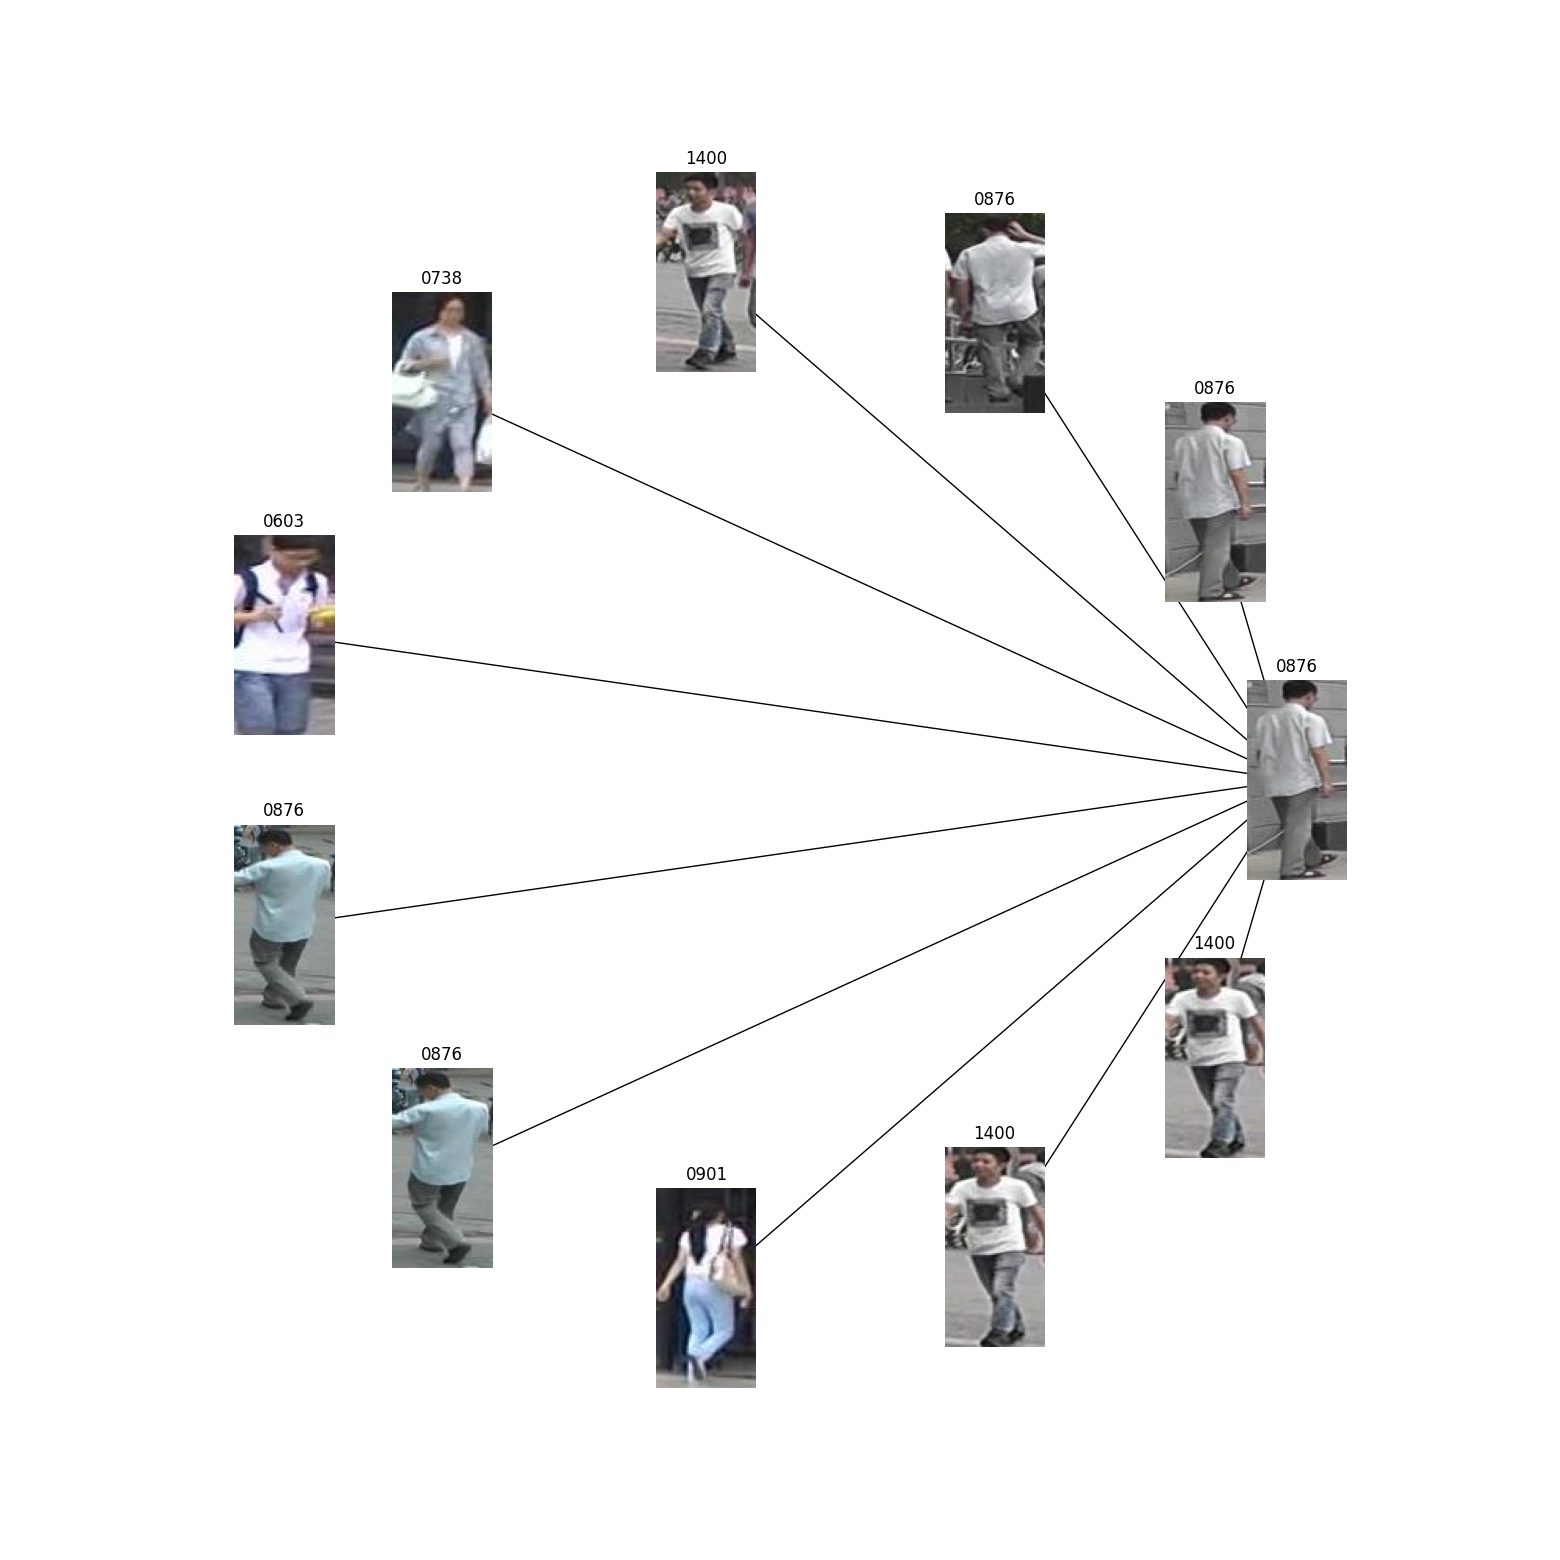

In [62]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distances, no_of_closest = 10);